In [ ]:
# =============================
# Importar librerías necesarias
# =============================
import pickle
from gensim.models import Doc2Vec
from gensim.models import Doc2Vec
from statsbombpy import sb
import pandas as pd
import numpy as np
from collections import Counter
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from numpy.linalg import norm
from random import sample
import math
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from collections import defaultdict
import gc
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# =============================
# Cargar player_docs desde un archivo .pkl
# =============================
def load_player_docs(path):
    """
    Carga el objeto player_docs (Serie de tokens por jugador)
    desde un archivo pickle (.pkl).
    """
    with open(path, "rb") as f:
        player_docs = pickle.load(f)
    print(f"   player_docs cargado correctamente desde: {path}")
    print(f"   Jugadores: {len(player_docs)} | Tokens totales: {sum(len(d) for d in player_docs.values):,}")
    return player_docs

# =============================
# MODELO:
# =============================
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import numpy as np

def train_embeddings(player_docs, w2v_dim=128, d2v_dim=128, window=8, min_count=1, workers=4, epochs=12):
    corpus = list(player_docs.values)
    if not corpus:
        raise ValueError("Corpus vacío: no hay documentos de jugadores.")

    total_tokens = int(np.sum([len(d) for d in corpus]))
    print(f"Entrenando Word2Vec con {len(corpus)} documentos y {total_tokens:,} tokens...")

    w2v = Word2Vec(
        sentences=corpus,
        vector_size=w2v_dim,
        window=window,
        min_count=min_count,
        sg=1,             # Skip-gram
        negative=10,
        workers=workers,
        epochs=epochs
    )

    tagged = [TaggedDocument(words=doc, tags=[str(pid)]) for (pid,_), doc in player_docs.items()]
    print(f"Entrenando Doc2Vec ({len(tagged)} jugadores)...")

    d2v = Doc2Vec(
        documents=tagged,
        vector_size=d2v_dim,
        window=window,
        min_count=min_count,
        dm=1,            # PV-DM
        negative=10,
        workers=workers,
        epochs=epochs
    )

    print("✅ Entrenamiento completado.")
    return w2v, d2v

# Archivos de entrada (ajusta las rutas según tus nombres)
path_docs = "Datos/player_docs_20251023-145024.pkl.gz"
path_d2v  = "Datos/doc2vec_128d_20251023-145024.model"

# Carga los objetos
player_docs = load_player_docs(path_docs)
# d2v = load_doc2vec_model(path_d2v)

pid = str(list(player_docs.index.get_level_values(0))[0])  # primer jugador
#print("\nEjemplo de vector Doc2Vec del primer jugador:")
#print(d2v.dv[pid][:10])  # muestra los primeros 10 valores del embedding
#w2v, d2v = train_embeddings(player_docs, w2v_dim=128, d2v_dim=128, window=8, min_count=1, workers=4, epochs=12)
def build_w2v_sif(player_docs, w2v, a=1e-3, stop_top=25, remove_pc=True):
    # Función que crea embeddings por jugador usando SIF (smooth inverse frequency) sobre vectores Word2Vec
    # recibe: a (hiperparámetro del peso SIF), stop_top (cantidad de tokens globales mas frecuentes ignorar) y remove_pc (si True, quita el primer componente principal)
    tok_counts = Counter()  # contador de frecuencias totales de tokens
    total_tokens = 0        # contador de total de tokens
    for doc in player_docs.values:
        # recorre cada documento 
        tok_counts.update(doc) # suma frecuencias de tokens
        total_tokens += len(doc) # acumula cuantos tokens hay en total
    pw = {w: tok_counts[w]/total_tokens for w in tok_counts} # calcula p(w): probabilidad global de cada token = frecuencia total / total de tokens

    # Stop-tokens (los más comunes a nivel documento)
    df_counts = Counter()
    for doc in player_docs.values:
        # cuenta en cuantos documentos aparece cada token para contar una vez por doc
        df_counts.update(set(doc))
    stop = {w for w, _ in sorted(df_counts.items(), key=lambda x: x[1], reverse=True)[:stop_top]} # ordena tokens por DF descendente y toma los stop_top más comunes como stop-tokens a ignorar
    print(f"[SIF] Ignorando {len(stop)} tokens muy frecuentes:", list(stop)[:10], "...") # lista de stop-tokens ignorados

    # 1) Embedding SIF por jugador = promedio ponderado por a/(a+p(w))
    pid_list, name_list, vec_list = [], [], [] # listas para acumular ids, nombres y vectores SIF por jugador
    for (pid, pname), doc in player_docs.items(): 
        # itera jugador por jugador; arreglos para vectores de palabras y sus pesos SIF
        wvecs = []
        weights = []
        for w in doc:
            # Recorre tokens del documento
            if w in stop or w not in w2v.wv: 
                # salta si es stop-token o no existe en el vocabulari de W2V
                continue
            weight = a / (a + pw.get(w, 1e-9)) # calcula el peso SIF: tokens muy frecuentes -> peso menor
            wvecs.append(w2v.wv[w])
            weights.append(weight) # agrega el vector del token y su peso
        if wvecs:
            # si hubo tokens válidos
            v = np.average(wvecs, axis=0, weights=weights) # calcula el promedio ponderado por SIF
            pid_list.append(pid); name_list.append(pname); vec_list.append(v) # guarda pid, nombre y el vector resultante

    V = np.vstack(vec_list) # apila todos los vectores de jugadores en una matriz V

    # 2) Quitar la 1ª componente principal (dirección común)
    if remove_pc and len(vec_list) >= 2:
        # si se solicita: elimina la dirección común 
        pca = PCA(n_components=1) # ajusta una PCA de 1 componente
        pca.fit(V)
        u = pca.components_[0]  # primer componente (dirección dominante)
        # proyección ortogonal: v' = v - (u ⋅ v) u
        V = V - (V @ u[:, None]) * u[None, :]

    # Normaliza por si acaso
    norms = np.linalg.norm(V, axis=1, keepdims=True) + 1e-12 # normaliza a norma unitaria
    V = V / norms

    # Diccionario pid -> (name, vector)
    sif_pool = {pid: (name_list[i], V[i]) for i, pid in enumerate(pid_list)}
    return sif_pool
def build_w2v_pool(player_docs, w2v, method='mean'):
    # Construye un embedding por jugador promediando los embeddings Word2Vec de sus tokens
    vecs = {} # diccionario para almacenar los vectores por jugador player_id -> (player_name, vector)
    for (pid, pname), doc in player_docs.items():
        # itera por cada jugador: la llave del índice es (player_id, player_name) y el valor es la lista de tokens
        emb = [w2v.wv[w] for w in doc if w in w2v.wv] # para cada token del documento, toma su vector en el vocabulario w2v.wv solo si existe
        if not emb: 
            #si el jugador no tiene tokens presentes en el vocabulario Word2Vec, lo salta
            continue
        if method == 'mean':
            # hace pooling: calcula el promedio de los vectores de tokens para obtener el vector del jugador
            v = np.mean(emb, axis=0)
        else:
            v = np.mean(emb, axis=0)
        vecs[pid] = (pname, v) # guarda para ese player_id el par (player_name, vector_agregado)
    return vecs # devuelve el diccionario de embeddings por jugador

w2v_pool = build_w2v_pool(player_docs, w2v, method='mean') # construye el pool de vectores Word2Vec por jugador usando media.

sif_pool = build_w2v_sif(player_docs, w2v, a=1e-3, stop_top=35, remove_pc=True) # genera el pool SIF con a=1e-3 ignorando los 35 tokens más comunes y removiendo la primera PC


   player_docs cargado correctamente desde: C:/Users/alexa/Documents/Alexa/Escuela/ITAM/Hackathon_futbol/2025-jugadores/data/player_docs_ligamx_2021_2025.pkl
   Jugadores: 970 | Tokens totales: 2,841,541
[SIF] Ignorando 35 tokens muy frecuentes: ['Pass_Z_Med_Der', 'Pass_Z_Ata_Cen', 'Carry_Z_Def_Der_BajoPresion', 'Carry_Z_Def_Izq', 'Ball Recovery_Z_Def_Cen', 'Pass_Z_Med_Izq_BajoPresion', 'Carry_Z_Def_Izq_BajoPresion', 'Pass_Z_Def_Izq', 'Carry_Z_Med_Izq_BajoPresion', 'Pressure_Z_Med_Der'] ...


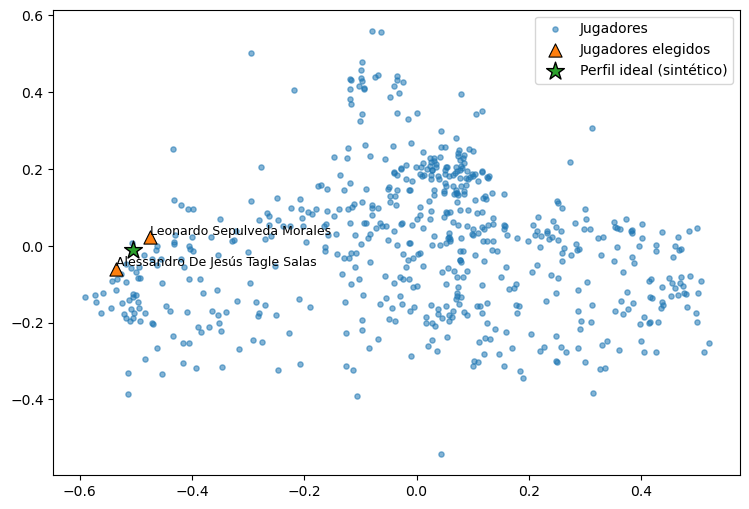

In [ ]:
def plot_projection_2d_highlight(pool, vec_syn=None, chosen_pids=None,
                                 sample=600, annotate=True, random_state=42):
    """
    Proyecta un subconjunto de jugadores en 2D y resalta:
      - el vector sintético (estrella grande),
      - los jugadores elegidos (marcadores triangulares).
    pool: dict {pid: (name, vec)}
    vec_syn: np.array (opcional), vector sintético ya normalizado
    chosen_pids: lista de player_id a resaltar (opcional)
    """
    chosen_pids = [] if chosen_pids is None else list(chosen_pids)

    # 1) Prepara una muestra para no saturar el gráfico
    items = list(pool.items())
    if len(items) > sample:
        rng = np.random.default_rng(random_state)
        idx = rng.choice(len(items), size=sample, replace=False)
        items = [items[i] for i in idx]

    # Asegura que los elegidos estén en la muestra
    keep = {pid for pid, _ in items}
    for pid in chosen_pids:
        if pid in pool and pid not in keep:
            items.append((pid, pool[pid]))  # fuerza su inclusión
            keep.add(pid)

    # 2) Construye la matriz para PCA
    names, pids, M = [], [], []
    for pid, (name, v) in items:
        pids.append(pid)
        names.append(name)
        M.append(v)
    M = np.vstack(M)

    # Incluye el sintético en el ajuste para que la proyección sea coherente
    pca = PCA(n_components=2, random_state=random_state)
    pca.fit(M if vec_syn is None else np.vstack([M, vec_syn]))

    XY = pca.transform(M)

    # 3) Dibuja nubes y resaltados
    plt.figure(figsize=(7.6, 5.2))
    # nube general
    plt.scatter(XY[:, 0], XY[:, 1], s=14, alpha=0.55, label="Jugadores")

    # resalta jugadores elegidos
    if chosen_pids:
        x_ch, y_ch, labels_ch = [], [], []
        for pid in chosen_pids:
            if pid in pids:
                i = pids.index(pid)
                x_ch.append(XY[i, 0]); y_ch.append(XY[i, 1])
                labels_ch.append(names[i] if names[i] else str(pid))
        if x_ch:
            plt.scatter(x_ch, y_ch, s=90, marker="^", edgecolor="k", linewidths=0.8,
                        label="Jugadores elegidos")
            if annotate:
                for (x, y, lab) in zip(x_ch, y_ch, labels_ch):
                    plt.text(x, y, lab, fontsize=9, ha="left", va="bottom")

    # vector sintético
    if vec_syn is not None:
        syn_xy = pca.transform(vec_syn.reshape(1, -1))
        plt.scatter(syn_xy[0, 0], syn_xy[0, 1], s=180, marker="*",
                    edgecolor="k", linewidths=1.0, label="Perfil ideal (sintético)")
        #if annotate:
            #plt.text(syn_xy[0, 0], syn_xy[0, 1], "Perfil ideal", fontsize=10,
            #         ha="center", va="bottom", fontweight="bold")

    # 4) Títulos y estética “no técnica”
    plt.legend()
    plt.tight_layout()
    plt.show()
    
# ids elegidos y pesos
pid1, pid2 = 409157.0, 436788.0
alpha, beta = 0.6, 0.4

# elige el espacio y su pool (ej.: SIF)
SPACE = 'sif'
POOL  = sif_pool  # o d2v_pool / w2v_pool según espacio

# sintetiza
E_syn, usados = synthesize_embedding(
    components=[(pid1, alpha), (pid2, beta)],
    space=SPACE,
    normalize=True,
    sif_pool=sif_pool, d2v_pool=d2v_pool, w2v_pool=w2v_pool
)

# grafica resaltando a los jugadores elegidos y el perfil sintético
plot_projection_2d_highlight(
    pool=POOL,
    vec_syn=E_syn,
    chosen_pids=[pid1, pid2],
    sample=600,
    annotate=True
)